In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sympy as smp
from matplotlib import animation
from matplotlib.animation import PillowWriter

A diagram of the problem at hand:

* The entire system depends on only two angles: $\theta_1$ and $\theta_2$
* We will use these variables as our free variables

<p align="center">
  <img src="../images/l_diagram1.png" alt="drawing" width="300" align="center"/>
</p>

Define all symbols we need for this problem using sympy:

In [27]:
t, g, l1, l2, m1, m2, m3, k, L0 = smp.symbols('t g l_1 l_2 m_1 m_2 m_3 k L_0')
the1, the2 = smp.symbols(r'\theta_1 \theta_2', cls=smp.Function)

Define $\theta(t)$ and $\dot{\theta}(t)$ and $\ddot{\theta}(t)$

In [28]:
the1 = the1(t)
the2 = the2(t)
the1_d = smp.diff(the1, t)
the2_d = smp.diff(the2, t)
the1_dd = smp.diff(the1_d, t)
the2_dd = smp.diff(the2_d, t)

Define the $x$ and $y$ coordinates of all three masses

In [29]:
x1 = l1*smp.cos(the1)
y1 = -l1*smp.sin(the1)
x2 = 2*x1
y2 = 0
x3 = x2 + l2*smp.sin(the2)
y3 = -l2*smp.cos(the2)

Define both kinetic and potential energy:

* Kinetic energy $T$ comes from the motion of the three masses
* Potential energy $V$ comes from both the gravitational potential energy of the masses $mgy$ and the potential energy in the spring $\frac{1}{2}kx^2$ where $x=x_2 - L_0$

In [34]:
T = smp.Rational(1,2) * m1 * (smp.diff(x1,t)**2 + smp.diff(y1,t)**2) \
    +smp.Rational(1,2) * m2 * (smp.diff(x2,t)**2 + smp.diff(y2,t)**2) \
    +smp.Rational(1,2) * m3 * (smp.diff(x3,t)**2 + smp.diff(y3,t)**2)

V = m1*g*y1 + m2*g*y2 + m3*g*y3 +smp.Rational(1,2) * k * (x2-L0)**2
L =T-V

Now we can look at the Lagrangian

In [35]:
L

g*l_1*m_1*sin(\theta_1(t)) + g*l_2*m_3*cos(\theta_2(t)) - k*(-L_0 + 2*l_1*cos(\theta_1(t)))**2/2 + 2*l_1**2*m_2*sin(\theta_1(t))**2*Derivative(\theta_1(t), t)**2 + m_1*(l_1**2*sin(\theta_1(t))**2*Derivative(\theta_1(t), t)**2 + l_1**2*cos(\theta_1(t))**2*Derivative(\theta_1(t), t)**2)/2 + m_3*(l_2**2*sin(\theta_2(t))**2*Derivative(\theta_2(t), t)**2 + (-2*l_1*sin(\theta_1(t))*Derivative(\theta_1(t), t) + l_2*cos(\theta_2(t))*Derivative(\theta_2(t), t))**2)/2

Get Lagrange's equations

$$\frac{\partial L}{\partial \theta_1} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}} = 0$$
$$\frac{\partial L}{\partial \theta_2} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}} = 0$$

In [40]:
LE1 = smp.diff(L, the1) - smp.diff(smp.diff(L, the1_d), t).simplify()
LE2 = smp.diff(L, the2) - smp.diff(smp.diff(L, the2_d), t).simplify()

Solve Lagranges equations (this assumes that `LE1` and `LE2` are both equal to zero)

* We solve these equations (which are **linear** in $\ddot{\theta_1}$ and $\ddot{\theta_2}$) for $\ddot{\theta_1}$ and $\ddot{\theta_2}$.

In [43]:
sols = smp.solve([LE1, LE2], (the1_dd, the2_dd),
                simplify=False, rational=False)

Now we have 

* $\frac{d^2 \theta_1}{dt^2} = ...$
* $\frac{d^2 \theta_2}{dt^2} = ...$

These are two second order ODEs! In python we can only solve systems of first order ODEs. Any system of second order ODEs can be converted as follows:

1. Define $z_1 = d\theta_1/dt$ and $z_2=d\theta_2/dt$
2. Then $dz_1/dt = d^2\theta_1/dt^2$ and $dz_2/dt = d^2\theta_2/dt^2$

Now we get a system of 4 first order ODEs (as opposed to 2 second order ones)

* $d z_1/dt = ...$
* $d\theta_1/dt = z_1$
* $d z_2/dt = ...$
* $d\theta_2/dt = z_1$

We need to convert the **symbolic** expressions above to numerical functions so we can use them in a numerical python solver. For this we use `smp.lambdify`

In [47]:
dz1dt_f = smp.lambdify((t,g,k,L0,m1,m2,m3,l1,l2,the1,the2,the1_d,the2_d), sols[the1_dd])
dz2dt_f = smp.lambdify((t,g,k,L0,m1,m2,m3,l1,l2,the1,the2,the1_d,the2_d), sols[the2_dd])
dthe1dt_f = smp.lambdify(the1_d, the1_d)
dthe2dt_f = smp.lambdify(the2_d, the2_d)

Now define $\vec{S} = (\theta_1, z_1, \theta_2, z_2)$. IF we're going to use an ODE solver in python, we need to write a function that takes in $\vec{S}$ and $t$ and returns $d\vec{S}/dt$. In other words, we need to define $d\vec{S}/dt (\vec{S}, t)$

* Our system of ODEs can be fully specified using $d\vec{S}/dt$ and depends only on $\vec{S}$ and $t$

In [50]:
def dSdt(S, t, g, k, L0, m1, m2, m3, l1, l2):
    the1, z1, the2, z2 = S
    return [
        dthe1dt_f(z1),
        dz1dt_f(t,g,k,L0,m1,m2,m3,l1,l2,the1,the2,z1,z2),
        dthe2dt_f(z2),
        dz2dt_f(t,g,k,L0,m1,m2,m3,l1,l2,the1,the2,z1,z2),
    ]

Solve the system of ODEs using scipys `odeint` method

In [51]:
t = np.linspace(0, 40, 1001) # s
g = 9.81 #m/s^2
k = 30 # N/m
m1=2 # kg
m2=2 # kg
m3=1 # kg
l1 = 1 # m
l2 = 1 # m
L0 = 1.5*l1 # m
ans = odeint(dSdt, y0=[1, -1, -1, 1], t=t, args=(g, k, L0, m1, m2, m3, l1, l2))

25 times per second (number of data points). This will be important for animating later on.

Can obtain $\theta_1(t)$ and $\theta_2(t)$ from the answer

In [55]:
the1 = ans.T[0]
the2 = ans.T[2]

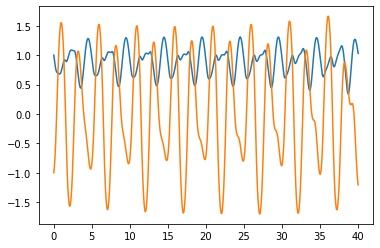

In [56]:
plt.plot(t, the1)
plt.plot(t, the2)

Here's a function that takes in $\theta_1$ and $\theta_2$ and returns the location (x,y) of the three masses. This will be used for animation

In [57]:
def get_x1y1x2y2x3y3(t, the1, the2, l1, l2):
    return (l1*np.cos(the1),
            -l1*np.sin(the1),
            2*l1*np.cos(the1),
            np.zeros(len(the1)),
            2*l1*np.cos(the1) + l2*np.sin(the2),
            -l2*np.cos(the2))

x1, y1, x2, y2, x3, y3 = get_x1y1x2y2x3y3(t, ans.T[0], ans.T[2], l1, l2)

Here is the code for a simple animation

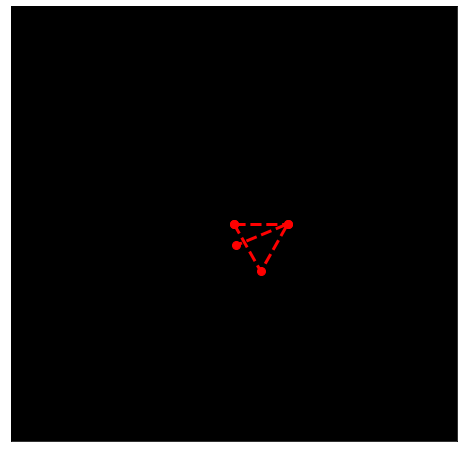

In [62]:
def animate(i):
    ln1.set_data([0, x1[i], x2[i], x3[i]], [0, y1[i], y2[i], y3[i]])
    ln2.set_data([0, x2[i]], [0, y2[i]])
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])    # enable this to hide y axis ticks
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ln2, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('pen.gif',writer='pillow',fps=25)